In [ ]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 16.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import Sastrawi
from wordcloud import WordCloud
import numpy as np
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from textblob import TextBlob
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [ ]:
from google.colab import files
data = files.upload()

Saving preprocessed_google_play_reviews.csv to preprocessed_google_play_reviews.csv


In [ ]:
data = pd.read_csv("preprocessed_google_play_reviews.csv")
data

,content,score,at
0,sangat bagus untuk membantu bapak ibu guru dal...,5,2024-11-09 10:26:43
1,sangat membantu app ini karena kami membutuhka...,5,2024-11-21 19:08:36
2,aplikasi paling top kereen banget lengkap yang...,5,2020-10-23 00:21:23
3,alhamdulillaah sangat membantu,5,2025-01-06 16:55:20
4,saya berikan bintang karena semua ikhtiar dem...,5,2020-09-29 22:34:58
...,...,...,...
1650,bagus,1,2015-03-10 08:14:12
1651,ok,1,2016-11-25 14:13:54
1652,sukses,1,2015-10-16 19:49:26
1653,siippp,1,2019-08-31 01:12:01


In [ ]:
data.isnull().sum()

,0
content,11
score,0
at,0


## Labeling

In [ ]:
data_unclean = data.copy()

In [ ]:
label = []
for index, row in data_unclean.iterrows():
    if row["score"] <= 2:
        label.append(0)  # Negatif
    elif row["score"] == 3:
        label.append(1)  # Netral
    else:
        label.append(2)  # Positif

data_unclean["label"] = label

In [ ]:
data_unclean['label'].value_counts()

,count
label,
2,1337
0,170
1,148


## Drop Duplicate

In [ ]:
data_unclean = data_unclean.drop_duplicates()
data_unclean

,content,score,at,label
0,sangat bagus untuk membantu bapak ibu guru dal...,5,2024-11-09 10:26:43,2
1,sangat membantu app ini karena kami membutuhka...,5,2024-11-21 19:08:36,2
2,aplikasi paling top kereen banget lengkap yang...,5,2020-10-23 00:21:23,2
3,alhamdulillaah sangat membantu,5,2025-01-06 16:55:20,2
4,saya berikan bintang karena semua ikhtiar dem...,5,2020-09-29 22:34:58,2
...,...,...,...,...
1650,bagus,1,2015-03-10 08:14:12,0
1651,ok,1,2016-11-25 14:13:54,0
1652,sukses,1,2015-10-16 19:49:26,0
1653,siippp,1,2019-08-31 01:12:01,0


## Drop Null

In [ ]:
data_unclean['content'].isnull().sum()
data_unclean = data_unclean.dropna(subset=['content'])
data_unclean

,content,score,at,label
0,sangat bagus untuk membantu bapak ibu guru dal...,5,2024-11-09 10:26:43,2
1,sangat membantu app ini karena kami membutuhka...,5,2024-11-21 19:08:36,2
2,aplikasi paling top kereen banget lengkap yang...,5,2020-10-23 00:21:23,2
3,alhamdulillaah sangat membantu,5,2025-01-06 16:55:20,2
4,saya berikan bintang karena semua ikhtiar dem...,5,2020-09-29 22:34:58,2
...,...,...,...,...
1650,bagus,1,2015-03-10 08:14:12,0
1651,ok,1,2016-11-25 14:13:54,0
1652,sukses,1,2015-10-16 19:49:26,0
1653,siippp,1,2019-08-31 01:12:01,0


In [ ]:
def contains_number(text):
    return bool(re.search(r'\d', str(text)))

data_unclean['clean_text'] = data_unclean['content'].apply(contains_number)

<ipython-input-33-77cb84de9133>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_text'] = data['content'].apply(contains_number)


In [ ]:
data_unclean.isnull().sum()

,0
content,0
score,0
at,0
label,0


## Normalize

In [ ]:
# Normalisasi
norm = {
    " yg " : " yang ",
    " bgt " : " banget ",
    " bgt" : " banget",
    " bangat " : " banget ",
    " pisan " : " banget ",
    " trimakasih " : " terima kasih ",
    "terimakasih" : " terima kasih",
    " terimakasih" : " terima kasih",
    " terimakasih " : " terima kasih ",
    " kereen " : " keren ",
    "alhamdulillaah " : " Alhamdulillah ",
    " setinggitingginya " : " tinggi ",
    " app " : " aplikasi ",
    " apk " : " aplikasi ",
    " apl " : " aplikasi ",
    " nusantara" : " Indonesia",
    " he " : " ",
    " full " : " penuh ",
    "mudahmudahan " : " semoga ",
    " dgn " : " dengan ",
    "dg " : "dengan ",
    " tertakit " : " terkait ",
    " pengapdian " : " pengabdian ",
    "mantab " : "mantap ",
    " mantab " : " mantap ",
    " mantab" : " mantap",
    " mantaaf" : " mantap",
    " mantaaaaap" : " mantap ",
    "mantul" : "mantap",
    "mantaaab" : "mantap",
    "mantap jiwa" : "mantap",
    " ppg" : " ppg ",
    " tdk " : " tidak ",
    " sy " : " saya ",
    "tolong " : " tolong ",
    " berbeling belit " : " berbelit ",
    " guruguru " : " guru ",
    " ijasah " : " ijazah ",
    " terhusus " : " terkhusus ",
    " dn " : " dan ",
    "sngat " : "sangat ",
    " fahammmm" : " paham",
    " oke" : " baik",
    " blm " : " belum ",
    " lg" : " lagi",
    " sip " : " bagus ",
    " asyik " : " seru ",
    " fun " : " seru ",
    " best " : " terbaik ",
    "good" : "bagus",
    "bagussss" : "bagus",
    "bagussss " : "bagus ",
    " bagussss" : " bagus",
    " bagussss " : " bagus ",
    "jos" : "bagus",
    "like" : "suka",
    "informatig" : "informatif",
    "siiiiip" : "bagus",
    "good job" : "bagus",
    "nice" : "bagus",
    "jozz" : "bagus",
    "msh " : "masih ",
    "easy " : "mudah ",
    " parmudahkan " : " mudahkan ",
    " jg " : " juga ",
    " km " : " kami ",
    "smg " : "semoga ",
    " kl " : " kalau ",
    " lg " : " lagi ",
    " jd " : " jadi ",
    " dpt " : " dapat ",
    "sngt " : "sangat ",
    " sngt " : " sangat ",
    " se x" : " sekali",
    " mmbntu " : " membantu ",
    " memudhkn " : " memudahkan ",
    "praktis" : " praktis",
    " yg": " yang",
    " ok": " baik",
    " oke": " baik",
    " banget": " sangat",
    " aplikasinya": " aplikasi",
    " sip": " baik",
    " tdk": " tidak",
    " gak": " tidak",
    " bgt": " sangat",
    " trs": " terus",
    " dr": " dari",
    " krn": " karena",
    " sdh": " sudah",
    " blm": " belum",
    " tp": " tapi",
    " sy": " saya",
    " sbg": " sebagai",
    " utk": " untuk",
    " dlm": " dalam",
    " sj": " saja",
    " sm": " sama",
    " pd": " pada",
    " jd": " jadi",
    " mnrt": " menurut",
    " trmksh": " terima kasih",
    " mksh": " terima kasih",
    " kereen": " keren",
    "huebat": " hebat",
    "siippp": "sip",
    " trimakasih": " terima kasih",
    " aplkasi ": " aplikasi ", " apalikasi ": " aplikasi ", " apliasi ": " aplikasi ",
    " baguss ": " bagus ", " baguuss ": " bagus ", " bgs ": " bagus ",
    " mantabb ": " mantap ", " mantul ": " mantap ", " mantep ": " mantap ",
    " sgtt ": " sangat ", " sngt ": " sangat ", " sangaat ": " sangat ",

    " tdk ": " tidak ", " gpp ": " tidak apa-apa ", " trs ": " terus ",
    " blm ": " belum ", " udh ": " sudah ", " bgt ": " banget ", " bgt": " banget",
    " gak ": " tidak ", " ga ": " tidak ", " gabisa ": " tidak bisa ", " gaboleh ": " tidak boleh ",

    " log ": " login ", " server down ": " server tidak tersedia ",
    " nyesel ": " menyesal ",

    " best ": " terbaik ", " vibes ": " suasana ", " stylish ": " bergaya ",
    " worth ": " layak ", " simple ": " mudah ", " early ": " awal ",

    " kudu ": " harus ", " hrs ": " harus ", " jk ": " jika ", " dg ": " dengan ",
    " jd ": " jadi ", " problem ": " masalah ", " iru ": " itu ",
    " kereen": " keren",
    "huebat": " hebat",
    "siippp": "sip",
    " mendanlut": " mendownload",
    " logen": " login",
    " lht": " lihat",
    " yng": " yang",
    " laah": " lah",
    " tidakmpang": " gampang",
    "siip": "sip",
    " donlod": " download",
    " bs ": " bisa ",
    "gak ": " tidak ",
    "gkmana ": " bagaimana ",
    " betmanfaat ": " bermanfaat ",
    " dlm ": " dalam ",
    " aplikasix ": " aplikasinya ",
    " hax ": " hanya ",
    " gk ": " tidak ",
    " log in": " login ",
    " sllu ": " selalu ",
    " ggal ": " gagal ",
    " daribrowser ": " dari browser ",
    "error": "error ",
    "entah ": "tidak tau ",
    " lelet ": " lambat ",
    " dn ": " dan ",
    "kaga ": "tidak ",
    "eror ": "error ",
    " erorre ": " error ",
    " nggak ": " tidak ",
    " donlot ": " download ",
    " males ": " malas ",
    " tdk ": " tidak ",
    " gak ": " tidak ",
    " pasword": " password ",
    " dk ": " tidak ",
    " lgsung ": " langsung ",
    "knpa ": " kenapa ",
    " bisaaa ": " bisa ",
    "updet": "update",
    "login": "login ",
    "trims ": "terima ",
    " blm ": " belum ",
    " sklh ": " sekolah ",
    " tidk ": " tidak ",
    "singkron": "sinkron",
    "thankss": "terima kasih",
    "ngak": "tidak",
    "danlut": "download",
    "thanks": " terima kasih",
    " kpn ": " kapan ",
    "trimksh": "terima kasih",
    "ptkterimakasih": "ptk terima kasih",
    "mantaaap": "mantap",
    "baguuss": "bagus",
    "trima ksh": "terima kasih",
    "thanks": "terima kasih",
    "sipppppp": "sip",
    "mantaaaap": "mantap",
    "siiiippppp": "sip",
    "hebet": "hebat",
    "sipzzzz": "sip",
    "mantappp": "mantap",
    "mantaaap": "mantap",
    "kereeeeen": "keren",
    "mantaaabbbb": "mantab",
    "siiiip": "sip",
    "siiipppp": "sip",
    "bagusssss": "bagus",

}

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

data_unclean['content'] = data_unclean['content'].apply(lambda x: normalisasi(x))
data_unclean

<ipython-input-12-c5fa8312b3bd>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unclean['content'] = data_unclean['content'].apply(lambda x: normalisasi(x))


,content,score,at,label
0,sangat bagus untuk membantu bapak ibu guru dal...,5,2024-11-09 10:26:43,2
1,sangat membantu aplikasi ini karena kami membu...,5,2024-11-21 19:08:36,2
2,aplikasi paling top keren sangat lengkap yang ...,5,2020-10-23 00:21:23,2
3,Alhamdulillah sangat membantu,5,2025-01-06 16:55:20,2
4,saya berikan bintang karena semua ikhtiar dem...,5,2020-09-29 22:34:58,2
...,...,...,...,...
1650,bagus,1,2015-03-10 08:14:12,0
1651,ok,1,2016-11-25 14:13:54,0
1652,sukses,1,2015-10-16 19:49:26,0
1653,sip,1,2019-08-31 01:12:01,0


In [ ]:
data_unclean.to_csv('dataWithLabel.csv', index=False)

In [ ]:
data_unclean['label'].sum()

2805

## Stopwords

In [ ]:
data_clean = data_unclean.copy()

In [ ]:
more_stop_words = []

stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text


data_clean['content'] = data_clean['content'].apply(lambda x: stopword(x))
data_clean.head()

,content,score,at,label
0,sangat bagus membantu bapak ibu guru melihat d...,5,2024-11-09 10:26:43,2
1,sangat membantu aplikasi karena membutuhkan in...,5,2024-11-21 19:08:36,2
2,aplikasi paling top keren sangat lengkap membu...,5,2020-10-23 00:21:23,2
3,Alhamdulillah sangat membantu,5,2025-01-06 16:55:20,2
4,berikan bintang semua ikhtiar kebaikan walaup...,5,2020-09-29 22:34:58,2


## Tokenize

In [ ]:
tokenized = data_clean['content'].apply(lambda x:x.split())
tokenized

,content
0,"[sangat, bagus, membantu, bapak, ibu, guru, me..."
1,"[sangat, membantu, aplikasi, karena, membutuhk..."
2,"[aplikasi, paling, top, keren, sangat, lengkap..."
3,"[Alhamdulillah, sangat, membantu]"
4,"[berikan, bintang, semua, ikhtiar, kebaikan, w..."
...,...
1650,[bagus]
1651,[]
1652,[sukses]
1653,[sip]


## Stemming

In [ ]:
# def stemming(text_cleaning):
#   factory = StemmerFactory()
#   stemmer = factory.create_stemmer()
#   do = []
#   for w in text_cleaning:
#     dt = stemmer.stem(w)
#     do.append(dt)
#   d_clean = []
#   d_clean = " ".join(do)
#   print(d_clean)
#   return d_clean

# tokenized = tokenized.apply(stemming)


def stemming(text_cleaning):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    do = []
    for w in text_cleaning:
        if " " in w:  # Cek apakah ada spasi dalam string (lebih dari satu kata)
            dt = stemmer.stem(w)
        else:
            dt = w  # Jika hanya satu kata, tidak dilakukan stemming
        do.append(dt)
    d_clean = " ".join(do)
    print(d_clean)
    return d_clean
tokenized = tokenized.apply(stemming)

sangat bagus membantu bapak ibu guru melihat datanya cepat
sangat membantu aplikasi karena membutuhkan informasi terima kasih simpatika
aplikasi paling top keren sangat lengkap membuat aplikasi pinter sangat diberi kecerdasan ilmu mau berbagi terima kasih semoga sukses selalu
Alhamdulillah sangat membantu
berikan bintang semua ikhtiar kebaikan walaupun perlu pengembangan berikan apresiasi tinggi terima kasih aplikasi sangat bermanfaat kami guru diseluruh Indonesia
kasih penuh bintang ada sayaarat nya he permudah ketika lupa password dah berbagai cara apapun saya ikuti instruksi reset password belum berhasil hingga sekarang
aplikasi simpel mudah dipahami semoga masa depan aplikasi simpatika memberikan banyak solusi kbm lingkungan kemenag
mudah mengerjakan terutama apabila kesalahan pengisian data mudah diperbaiki
layanannya sangat bagus membantu menyiapkan dokumen
terima kasih adanya aplikasi bisa terbantu cepat memantau data dan mendapatkan informasi kemenag
siap simpatika layanan komu

In [ ]:
tokenized.to_csv('preprocessed_data.csv', index=False)
preprocessed_data = pd.read_csv('preprocessed_data.csv')
preprocessed_data.head()

,content
0,sangat bagus membantu bapak ibu guru melihat d...
1,sangat membantu aplikasi karena membutuhkan in...
2,aplikasi paling top keren sangat lengkap membu...
3,Alhamdulillah sangat membantu
4,berikan bintang semua ikhtiar kebaikan walaupu...


### Tidak perlu dulu

In [ ]:
data_stemming = data_stemming.rename(columns={"content": "content_stemming"})

In [ ]:
at1 = data_unclean["content"]
at2 = data_stemming["content_stemming"]
att2 = data_unclean["label"]

result = pd.concat([at1, at2, att2], axis=1)

In [ ]:
result

,content,content_stemming,label
0,sangat bagus untuk membantu bapak ibu guru dal...,sangat bagus bantu bapak ibu guru lihat data c...,1.0
1,sangat membantu app ini karena kami membutuhka...,sangat bantu app karena butuh informasi terima...,1.0
2,aplikasi paling top keren sangat lengkap yang ...,aplikasi paling top keren sangat lengkap buat ...,1.0
3,alhamdulillaah sangat membantu,alhamdulillaah sangat bantu,1.0
4,saya berikan bintang karena semua ikhtiar dem...,ikan bintang semua ikhtiar baik walaupun perlu...,1.0
...,...,...,...
997,NaN,admin coba bantu d web nama daftar di aplikasi...,NaN
1050,NaN,jadi aplikasi bagai mudah para sukwan jadi leb...,NaN
1387,NaN,cari ptk fungsi,NaN
1539,NaN,gagal hubung server,NaN


In [ ]:
files.upload()

Saving normalize_stemmed_data.csv to normalize_stemmed_data.csv


{'normalize_stemmed_data.csv': b'stemmed_data,score,at\nsangat bagus untuk bantu bapak ibu guru dalam lihat data dengan cepat,5,2024-11-09 10:26:43\nbantu aplikasi butuh informasi terima kasih simpatika,5,2024-11-21 19:08:36\naplikasi top keren lengkap aplikasi pinter cerdas ilmu bagi terima kasih moga sukses,5,2020-10-23 00:21:23\nalhamdulillah bantu,5,2025-01-06 16:55:20\nbintang ikhtiar baik kembang apresiasi terima kasih aplikasi manfaat guru seluruh indonesia,5,2020-09-29 22:34:58\nkasih penuh bintang sayaarat nya he tolong mudah lupa password dah apa ikut instruksi reset password hasil,5,2020-02-19 11:15:21\naplikasi simpel mudah paham moga aplikasi simpatika solusi kbm lingkung kemenag,5,2020-06-13 09:21:51\nmudah salah isi data mudah baik,5,2020-01-31 16:15:11\nlayan sangat bagus dan bantu dalam siap dokumen,5,2023-03-02 12:22:32\nterima kasih aplikasi bantu cepat pantau data informasi kemenag,5,2021-06-07 03:12:39\nsimpatika layan komunikasi manfaat guru kait informasi kemenag

In [ ]:
data_pre = pd.read_csv("normalize_stemmed_data.csv")
data_pre

,stemmed_data,score,at
0,sangat bagus untuk bantu bapak ibu guru dalam ...,5,2024-11-09 10:26:43
1,bantu aplikasi butuh informasi terima kasih si...,5,2024-11-21 19:08:36
2,aplikasi top keren lengkap aplikasi pinter cer...,5,2020-10-23 00:21:23
3,alhamdulillah bantu,5,2025-01-06 16:55:20
4,bintang ikhtiar baik kembang apresiasi terima ...,5,2020-09-29 22:34:58
...,...,...,...
1639,bagus,1,2015-03-10 08:14:12
1640,baik,1,2016-11-25 14:13:54
1641,sukses,1,2015-10-16 19:49:26
1642,sip,1,2019-08-31 01:12:01


In [ ]:
clean_data = data_pre.dropna(subset=['stemmed_data'])
clean_data

,stemmed_data,score,at
0,sangat bagus untuk bantu bapak ibu guru dalam ...,5,2024-11-09 10:26:43
1,bantu aplikasi butuh informasi terima kasih si...,5,2024-11-21 19:08:36
2,aplikasi top keren lengkap aplikasi pinter cer...,5,2020-10-23 00:21:23
3,alhamdulillah bantu,5,2025-01-06 16:55:20
4,bintang ikhtiar baik kembang apresiasi terima ...,5,2020-09-29 22:34:58
...,...,...,...
1639,bagus,1,2015-03-10 08:14:12
1640,baik,1,2016-11-25 14:13:54
1641,sukses,1,2015-10-16 19:49:26
1642,sip,1,2019-08-31 01:12:01


In [ ]:
tokenized = clean_data['stemmed_data'].apply(lambda x:x.split())
tokenized

,stemmed_data
0,"[sangat, bagus, untuk, bantu, bapak, ibu, guru..."
1,"[bantu, aplikasi, butuh, informasi, terima, ka..."
2,"[aplikasi, top, keren, lengkap, aplikasi, pint..."
3,"[alhamdulillah, bantu]"
4,"[bintang, ikhtiar, baik, kembang, apresiasi, t..."
...,...
1639,[bagus]
1640,[baik]
1641,[sukses]
1642,[sip]


In [ ]:
tokenized.to_csv('databersih2.csv', index=False)
data_clean = pd.read_csv('databersih2.csv', encoding='latin1')
data_clean.head()

,stemmed_data
0,"['sangat', 'bagus', 'untuk', 'bantu', 'bapak',..."
1,"['bantu', 'aplikasi', 'butuh', 'informasi', 't..."
2,"['aplikasi', 'top', 'keren', 'lengkap', 'aplik..."
3,"['alhamdulillah', 'bantu']"
4,"['bintang', 'ikhtiar', 'baik', 'kembang', 'apr..."


## TF-ID (Melihat total kata)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [ ]:
preprocessed_data.shape

(1644, 1)

In [ ]:
data_unclean['label'].shape

(1644,)

In [ ]:
at1 = preprocessed_data["content"].dropna().reset_index(drop=True)
at2 = data_unclean["label"].dropna().reset_index(drop=True)

result = pd.concat([at1, at2], axis=1)
print(result.shape)  # Harus (1644, 2)


(1644, 2)


In [ ]:
print(type(at1))  # Pastikan ini pd.Series
print(type(at2))  # Pastikan ini pd.Series

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
result.isnull().sum()

,0
content,71
label,0


In [ ]:
result.shape

(1573, 2)

In [ ]:
result = result.dropna(subset=['content'])

In [ ]:
result

,content,label
0,sangat bagus membantu bapak ibu guru melihat d...,2
1,sangat membantu aplikasi karena membutuhkan in...,2
2,aplikasi paling top keren sangat lengkap membu...,2
3,Alhamdulillah sangat membantu,2
4,berikan bintang semua ikhtiar kebaikan walaupu...,2
...,...,...
1568,susah mendownload,0
1569,bagus,0
1570,sukses,0
1571,sip,0


In [ ]:
review = result['content']
cv = CountVectorizer()
term_fit = cv.fit(review)

In [ ]:
term_fit.vocabulary_

{'sangat': 1223,
 'bagus': 103,
 'membantu': 830,
 'bapak': 123,
 'ibu': 485,
 'guru': 446,
 'melihat': 824,
 'datanya': 277,
 'cepat': 243,
 'aplikasi': 73,
 'karena': 584,
 'membutuhkan': 842,
 'informasi': 509,
 'terima': 1424,
 'kasih': 589,
 'simpatika': 1324,
 'paling': 1062,
 'top': 1479,
 'keren': 655,
 'lengkap': 735,
 'membuat': 840,
 'pinter': 1137,
 'diberi': 298,
 'kecerdasan': 613,
 'ilmu': 500,
 'mau': 809,
 'berbagi': 148,
 'semoga': 1289,
 'sukses': 1375,
 'selalu': 1278,
 'alhamdulillah': 45,
 'berikan': 162,
 'bintang': 202,
 'semua': 1294,
 'ikhtiar': 491,
 'kebaikan': 606,
 'walaupun': 1537,
 'perlu': 1125,
 'pengembangan': 1098,
 'apresiasi': 84,
 'tinggi': 1470,
 'bermanfaat': 175,
 'kami': 578,
 'diseluruh': 353,
 'indonesia': 503,
 'penuh': 1114,
 'ada': 8,
 'sayaarat': 1235,
 'nya': 1016,
 'he': 466,
 'permudah': 1127,
 'ketika': 665,
 'lupa': 759,
 'password': 1071,
 'dah': 263,
 'berbagai': 147,
 'cara': 237,
 'apapun': 71,
 'saya': 1231,
 'ikuti': 497,
 'in

In [ ]:
term_frequency_all = term_fit.transform(review)
print(term_frequency_all)

  (0, 103)	1
  (0, 123)	1
  (0, 243)	1
  (0, 277)	1
  (0, 446)	1
  (0, 485)	1
  (0, 824)	1
  (0, 830)	1
  (0, 1223)	1
  (1, 73)	1
  (1, 509)	1
  (1, 584)	1
  (1, 589)	1
  (1, 830)	1
  (1, 842)	1
  (1, 1223)	1
  (1, 1324)	1
  (1, 1424)	1
  (2, 73)	2
  (2, 148)	1
  (2, 298)	1
  (2, 500)	1
  (2, 589)	1
  (2, 613)	1
  (2, 655)	1
  :	:
  (1562, 1380)	1
  (1563, 509)	1
  (1563, 824)	1
  (1563, 830)	1
  (1563, 1166)	1
  (1564, 205)	1
  (1564, 501)	1
  (1564, 679)	1
  (1564, 748)	1
  (1564, 884)	1
  (1564, 931)	1
  (1565, 113)	1
  (1565, 740)	1
  (1565, 1166)	1
  (1566, 536)	1
  (1566, 748)	1
  (1566, 1039)	1
  (1567, 716)	1
  (1567, 745)	1
  (1568, 876)	1
  (1568, 1380)	1
  (1569, 103)	1
  (1570, 1375)	1
  (1571, 1334)	1
  (1572, 468)	1


In [ ]:
ulasan_tf = review[1]
print(ulasan_tf)

sangat membantu aplikasi karena membutuhkan informasi terima kasih simpatika


In [ ]:
term_frequency = term_fit.transform([ulasan_tf])
term_frequency

<1x1569 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [ ]:
print(term_frequency)

  (0, 73)	1
  (0, 509)	1
  (0, 584)	1
  (0, 589)	1
  (0, 830)	1
  (0, 842)	1
  (0, 1223)	1
  (0, 1324)	1
  (0, 1424)	1


In [ ]:
dokumen = term_fit.transform(review)
tfidf_transformer = TfidfTransformer().fit(dokumen)
print(tfidf_transformer.idf_)

tfidf = tfidf_transformer.transform(term_frequency)
print(tfidf)

[7.66822825 7.66822825 7.26276314 ... 7.66822825 7.66822825 7.66822825]
  (0, 73)	0.23574237847928192
  (0, 509)	0.3313078303301295
  (0, 584)	0.46545090114619747
  (0, 589)	0.29078822655860714
  (0, 830)	0.1960483642368888
  (0, 842)	0.5006651261487084
  (0, 1223)	0.18251763171486984
  (0, 1324)	0.34669043225582613
  (0, 1424)	0.301414742675218


In [ ]:
train_negatif = result[result["label"] == 0]
train_negatif

,content,label
1476,aplikasinya tambah jelek sekali fotonya bisa d...,0
1477,masa buat aplikasi buat login tidak jika uji c...,0
1478,lama instalnya,0
1479,gagal masuk terusdipastikan dulu klo dah fix b...,0
1480,nih aplikasi buat mempermudah pelajar indonesi...,0
...,...,...
1568,susah mendownload,0
1569,bagus,0
1570,sukses,0
1571,sip,0


In [ ]:
from wordcloud import WordCloud

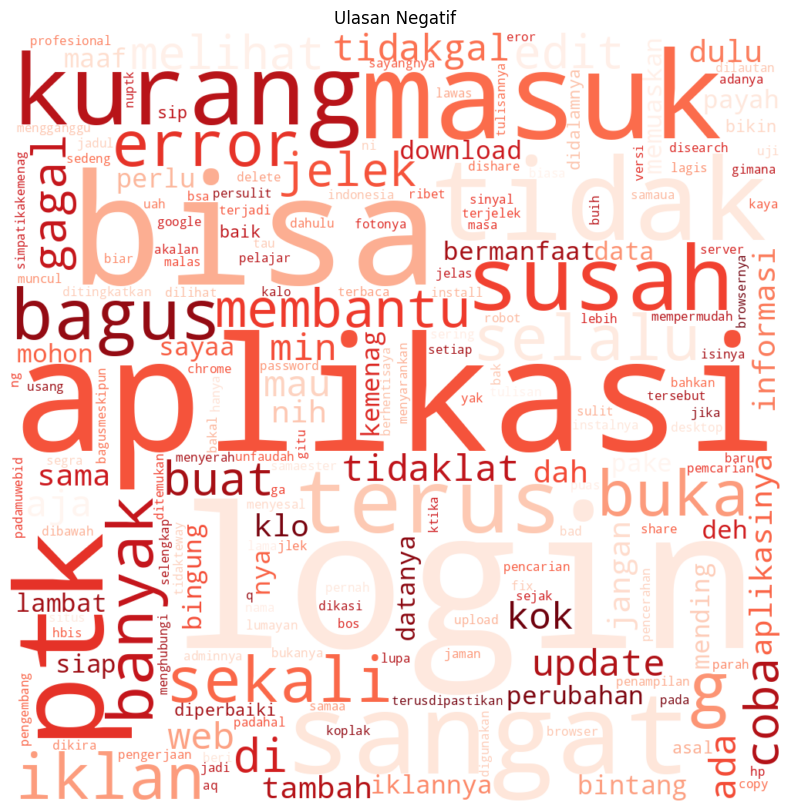

In [ ]:
all_text_s0 = ' '.join(word for word in train_negatif["content"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Ulasan Negatif")
plt.margins(x=0, y=0)
plt.show()

In [ ]:
train_netral = result[result["label"] == 1]
train_netral

,content,label
1329,kalau dipasang hp kok keluar sendiri terus yaa...,1
1330,menu edit biodata ada bisa disempurnakan terim...,1
1331,memungkingkan juga dicantumkan persyaratan inf...,1
1332,kasih tiga dulu kalau bagus saya tambah,1
1333,bisa login,1
...,...,...
1471,ga masukgalat terus,1
1472,app guna klo isi menunya cuma doang mending bu...,1
1473,menunya gtu tok dah gtu update mending webnya ...,1
1474,kali login selalu tidakgal padahal klo sayaa b...,1


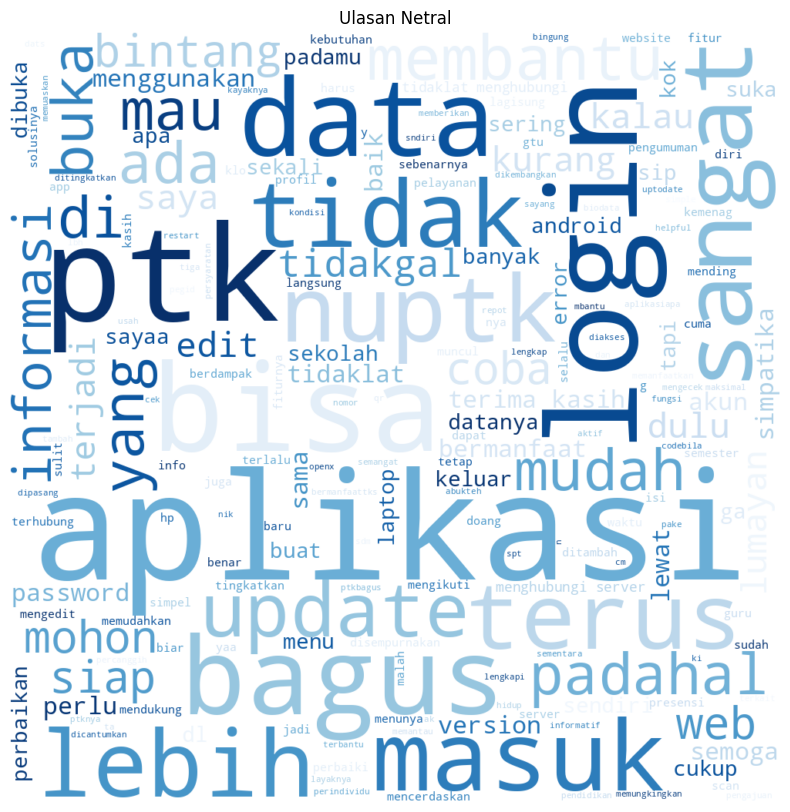

In [ ]:
all_text_s0 = ' '.join(word for word in train_netral["content"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Ulasan Netral")
plt.margins(x=0, y=0)
plt.show()

In [ ]:
train_positif = result[result["label"] == 2]
train_positif

,content,label
0,sangat bagus membantu bapak ibu guru melihat d...,2
1,sangat membantu aplikasi karena membutuhkan in...,2
2,aplikasi paling top keren sangat lengkap membu...,2
3,Alhamdulillah sangat membantu,2
4,berikan bintang semua ikhtiar kebaikan walaupu...,2
...,...,...
1324,featurnya upgrade jika berjalan dulu jaman pad...,2
1325,upgrade fiturnya bisa di gunakan ptk bermamfaa...,2
1326,mau login koq error cari ptk nya tidak lagikap,2
1327,pencarian ptk berfungsi,2


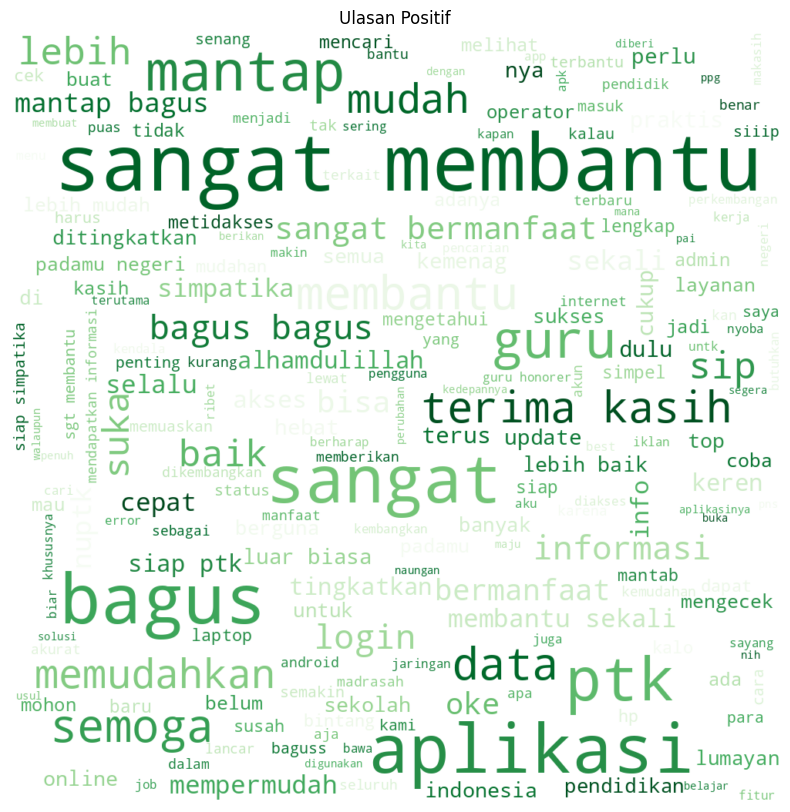

In [ ]:
all_text_s0 = ' '.join(word for word in train_positif["content"])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Ulasan Positif")
plt.margins(x=0, y=0)
plt.show()

<ipython-input-88-ec12f0c50c70>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sentimen_data = pd.value_counts(result["label"], sort=True)


<function matplotlib.pyplot.show(close=None, block=None)>

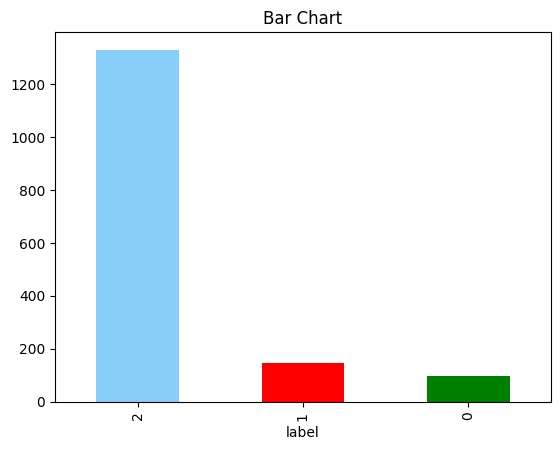

In [ ]:
sentimen_data = pd.value_counts(result["label"], sort=True)
sentimen_data.plot(kind='bar', color=['lightskyblue', 'red', 'green'])
plt.title("Bar Chart")
plt.show

## Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(result[['content']], result['label'])

In [ ]:
X_resampled = X_resampled['content']

<ipython-input-109-369337c55626>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='coolwarm')


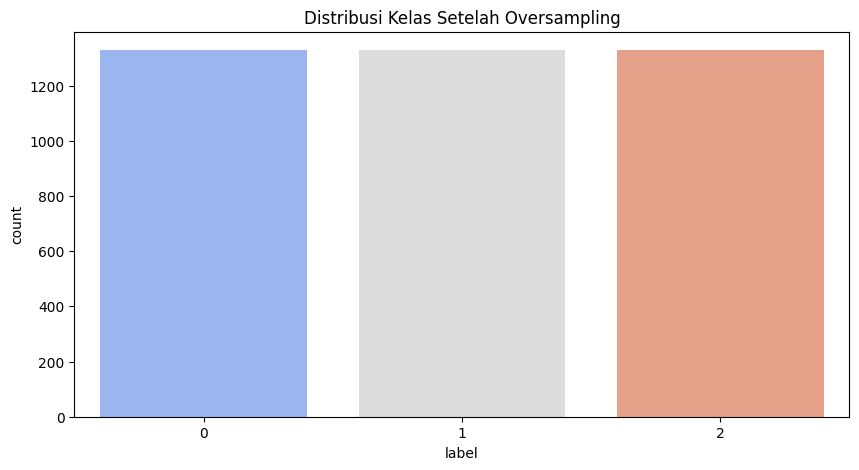

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(x=y_resampled, palette='coolwarm')
plt.title("Distribusi Kelas Setelah Oversampling")
plt.show()

## Training

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.3, stratify=y_resampled, random_state=30)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(result['content'], result['label'],
                                                    test_size=0.3, stratify=result['label'], random_state=30)

In [ ]:
import numpy as np

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(decode_error='replace', encoding='utf-8')

In [ ]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(2790, 1324)
(1197, 1324)


In [ ]:
X_train = X_train.toarray()

In [ ]:
X_test = X_test.toarray()

In [ ]:
print(X_train)

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=999)

params_NB = {'var_smoothing': np.logspace(0, -9, num=100)}
gscv_nb = GridSearchCV(estimator=nb,
                        param_grid=params_NB,
                        cv = cv_method,
                        verbose = 1,
                        scoring = 'accuracy')

gscv_nb.fit(X_train, y_train)
gscv_nb.best_params_

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


{'var_smoothing': 0.08111308307896872}

In [ ]:
nb = GaussianNB(var_smoothing= 0.08111308307896872)

In [ ]:
nb.fit(X_train, y_train)

GaussianNB(var_smoothing=0.08111308307896872)

In [ ]:
y_pred_nb = nb.predict(X_test)

In [ ]:
y_pred_nb

array([1, 2, 2, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7920


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
print('----- confusion matrix ------')
print(confusion_matrix(y_test, y_pred_nb))

print('----- classification report -----')
print(classification_report(y_test, y_pred_nb))

----- confusion matrix ------
[[371   0  28]
 [ 69 256  74]
 [ 43  35 321]]
----- classification report -----
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       399
           1       0.88      0.64      0.74       399
           2       0.76      0.80      0.78       399

    accuracy                           0.79      1197
   macro avg       0.80      0.79      0.79      1197
weighted avg       0.80      0.79      0.79      1197

